In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
google_apps = pd.read_csv('Google Play Store Apps.zip')
google_reviews = pd.read_csv('google_app_reviews.csv')

In [3]:
google_apps.rename(columns={'App Id': 'app_id'}, inplace=True)

In [4]:
apps = google_apps.merge(google_reviews, on="app_id", how='inner')

In [5]:
apps = apps.groupby('app_id').mean()

In [6]:
apps = apps[apps['Rating'] > 0]

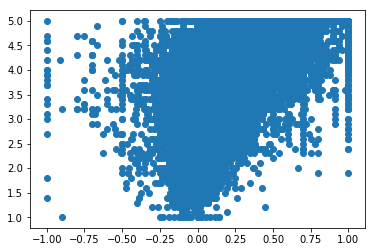

In [7]:
plt.scatter(apps['polarity'], apps['Rating'])

In [10]:
apps.columns

Index(['Rating', 'Rating Count', 'Minimum Installs', 'Maximum Installs',
       'Free', 'Price', 'Ad Supported', 'In App Purchases', 'Editors Choice',
       'Unnamed: 0', 'score', 'likes', 'polarity'],
      dtype='object')

In [11]:
features = ['Rating', 'polarity', 'Rating Count', 'Minimum Installs', 'Maximum Installs', 'Free', 'Price']
apps = apps[features]

In [21]:
apps['installs'] = (apps['Minimum Installs'] + apps['Maximum Installs']) / 2
apps.drop(['Minimum Installs', 'Maximum Installs'], axis=1, inplace=True)
apps.head(10)

,Rating,polarity,Rating Count,Free,Price,installs
app_id,,,,,,
ac.lite,4.1,0.023030,16677.0,True,0.0,1931505.0
ad.RailWiki,5.0,0.517929,111.0,True,0.0,149.5
ad.my.plan,3.4,0.240000,14.0,True,0.0,5234.0
advenworks.com.snakeblast,3.8,0.020089,8191.0,True,0.0,503805.5
ae.ac.sharjah.UOSmobile,3.8,0.236684,17.0,True,0.0,2998.0
ae.admedia.adfm,4.7,0.000000,20.0,True,0.0,1946.0
ae.admedia.qurankareem,4.5,0.250769,52.0,True,0.0,5262.0
ae.admedia.starfm,4.9,0.650000,20.0,True,0.0,2342.0
ae.adnoc.offers,3.5,0.187095,88.0,True,0.0,15137.5


In [22]:
# apps.head()
# apps.shape
# apps.columns
# apps.info()
# apps.describe()
apps.corr()
# apps.dropna().shape
# apps[apps.isna().any(axis=1)]

,Rating,polarity,Rating Count,Free,Price,installs
Rating,1.000000,0.493591,0.023201,-0.062361,0.045104,0.019397
polarity,0.493591,1.000000,-0.028042,0.007907,-0.000756,-0.032809
Rating Count,0.023201,-0.028042,1.000000,0.003840,-0.001806,0.742463
Free,-0.062361,0.007907,0.003840,1.000000,-0.716347,0.009484
Price,0.045104,-0.000756,-0.001806,-0.716347,1.000000,-0.006786
installs,0.019397,-0.032809,0.742463,0.009484,-0.006786,1.000000


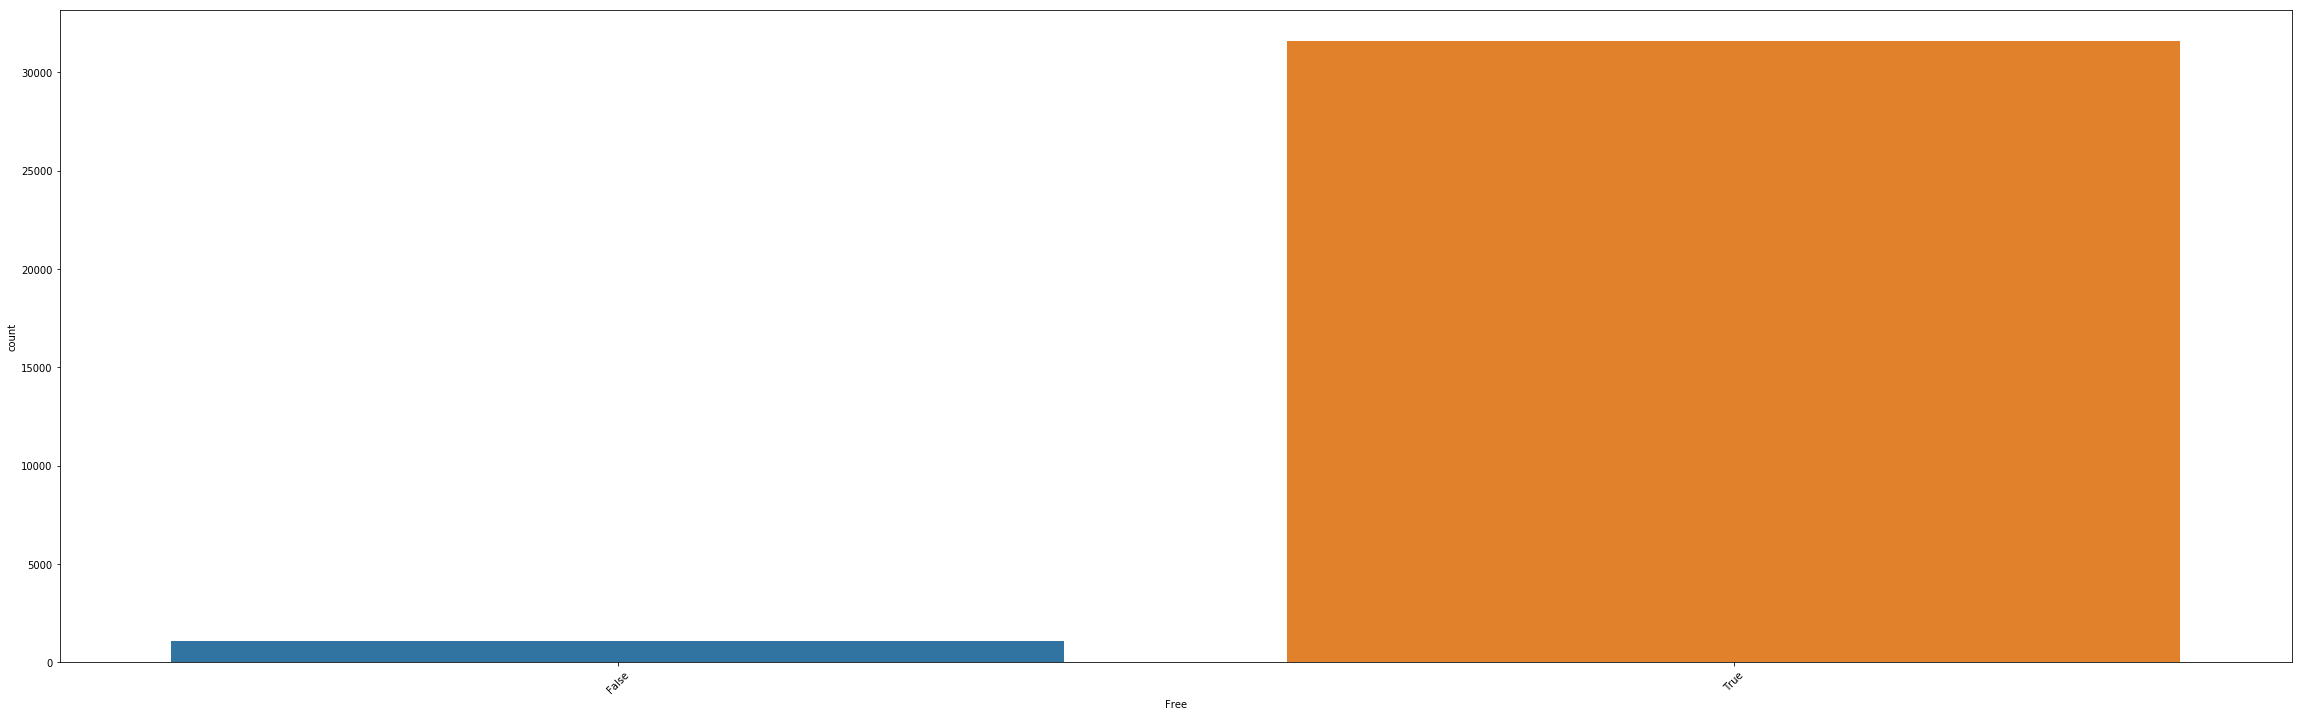

In [20]:
sns.countplot(x='Free', data=apps)
plt.rcParams["figure.figsize"] = (40,12)
plt.xticks(rotation=45) 
plt.show()

since most apps are free, we'll remove Free and Price columns

In [23]:
apps.drop(['Price', 'Free'], axis=1, inplace=True)

In [24]:
apps.head()

,Rating,polarity,Rating Count,installs
app_id,,,,
ac.lite,4.1,0.023030,16677.0,1931505.0
ad.RailWiki,5.0,0.517929,111.0,149.5
ad.my.plan,3.4,0.240000,14.0,5234.0
advenworks.com.snakeblast,3.8,0.020089,8191.0,503805.5
ae.ac.sharjah.UOSmobile,3.8,0.236684,17.0,2998.0


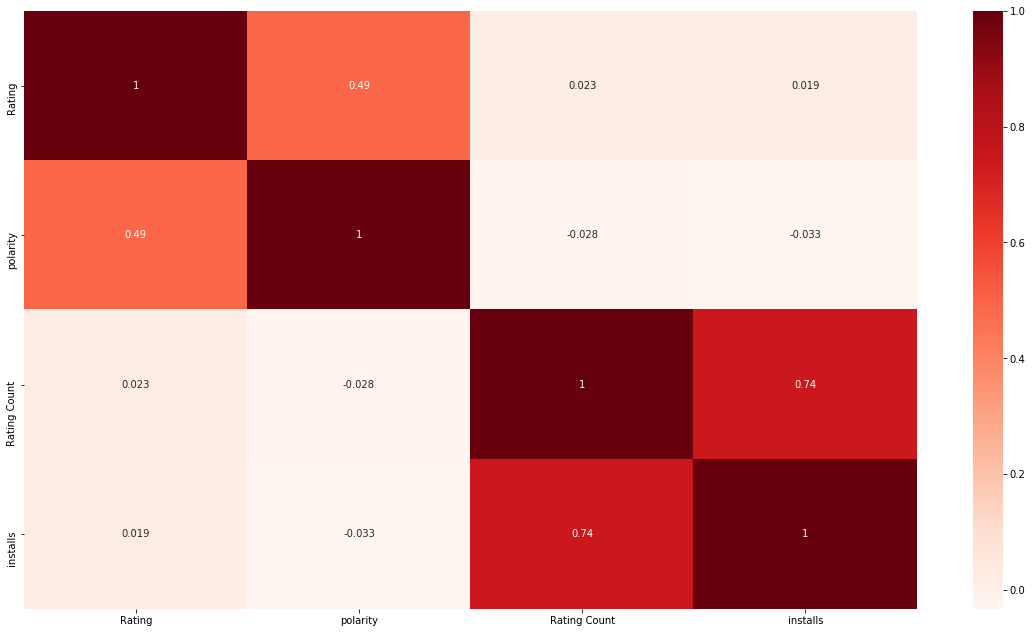

In [27]:
plt.figure(figsize=(20, 11))
cor = apps.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Select features and target

In [28]:
features = ['polarity', 'Rating Count', 'installs']
y = apps['Rating']
X = apps[features]

In [30]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)

# Decision Tree 🌲

In [41]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)


scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in [14]}
# min(scores, key=scores.get)
scores

14

In [49]:
decision_tree = DecisionTreeRegressor(max_leaf_nodes=7, random_state = 1)
decision_tree.fit(train_X, train_y)

val_predictions = decision_tree.predict(val_X)
print("MAE: ",mean_absolute_error(val_y, val_predictions))
print("Decision Tree Score: ", decision_tree.score(val_X, val_y))

MAE:  0.48354160968362403
Decision Tree Score:  0.3545693183804499


# Random Forest 🌳🌳🌳🌳

In [50]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(train_X, train_y)
forest_preds = forest_model.predict(val_X)
print("MAE: ",mean_absolute_error(val_y, forest_preds))
print("Random Forest Score: ", forest_model.score(val_X, val_y))

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MAE:  0.4773468667074914
Random Forest Score:  0.30731391061996083


# K Nearest Neighbours

In [52]:
model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=9)
)
model.fit(train_X, train_y)
print(model.score(val_X, val_y))

0.3470992842130002


# SVM

In [53]:
svm = make_pipeline(
    StandardScaler(), 
    SVR(C=1.0, epsilon=0.2)
)
svm.fit(train_X, train_y)

print("SVM Score: ", svm.score(val_X, val_y))

SVM Score:  0.33226986612456666
